In [1]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
!pip install PyWavelets

from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

Reading the Cross-sectional and Longitudinal MRI datasets

In [2]:
data_cross = pd.read_csv("/content/oasis_cross-sectional.csv")
data_long = pd.read_csv("/content/oasis_longitudinal.csv")
print(data_cross.info())
print(data_long.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 

Checking for null values

In [3]:
print(data_cross.isna().sum())
print("\n")
data_long.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64




,0
Subject ID,0
MRI ID,0
Group,0
Visit,0
MR Delay,0
M/F,0
Hand,0
Age,0
EDUC,0
SES,19


In [4]:
data_cross.dropna(subset=['CDR'],inplace=True)

In [5]:
data_cross.drop(columns=['ID','Delay'],inplace=True)
data_long = data_long.rename(columns={'EDUC':'Educ'})
data_long.drop(columns=['Subject ID','MRI ID','Group','Visit','MR Delay'],inplace=True)

Appending both the datasets

In [6]:
data = pd.concat([data_cross,data_long])
data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


In [7]:
data.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
count,608.000000,608.000000,570.00000,606.000000,608.000000,608.000000,608.00000,608.000000
mean,75.208882,10.184211,2.47193,27.234323,0.288651,1477.062500,0.73713,1.203597
std,9.865026,6.058388,1.12805,3.687980,0.377697,170.653795,0.04267,0.135091
min,33.000000,1.000000,1.00000,4.000000,0.000000,1106.000000,0.64400,0.876000
25%,70.000000,4.000000,2.00000,26.000000,0.000000,1352.500000,0.70400,1.118000
50%,76.000000,12.000000,2.00000,29.000000,0.000000,1460.000000,0.73600,1.202000
75%,82.000000,16.000000,3.00000,30.000000,0.500000,1569.000000,0.76625,1.297500
max,98.000000,23.000000,5.00000,30.000000,2.000000,2004.000000,0.84700,1.587000


<Axes: >

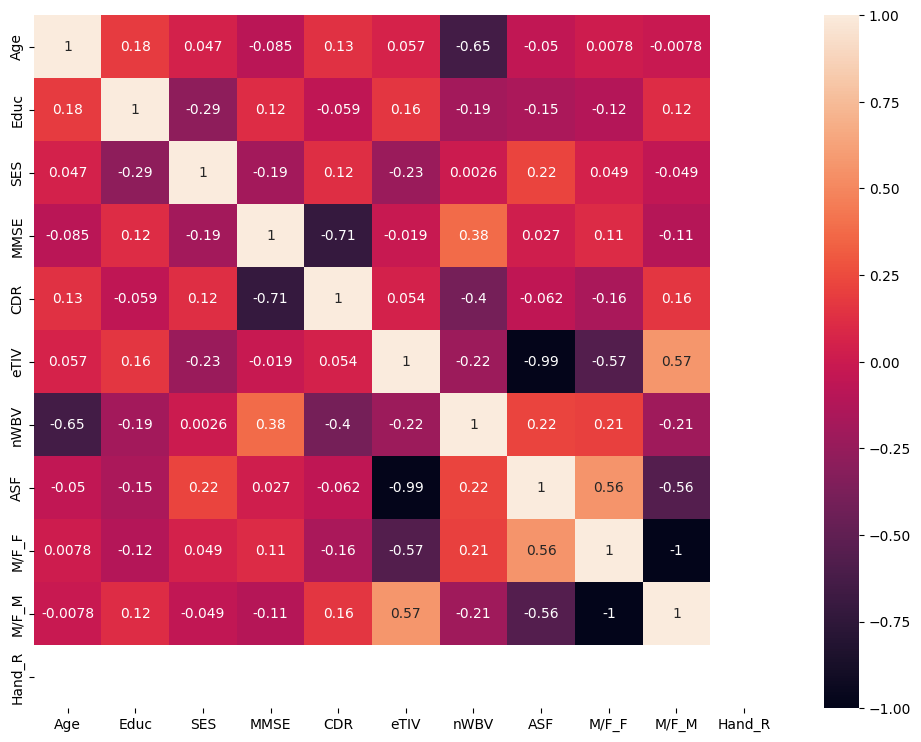

In [8]:
# One-Hot Encoding for 'M/F' and 'Hand'
data_encoded = pd.get_dummies(data, columns=['M/F', 'Hand'])

# Calculate correlation matrix
cor = data_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12,9))
sns.heatmap(cor, xticklabels=cor.columns.values, yticklabels=cor.columns.values, annot=True)


In [9]:
data.isna().sum()

,0
M/F,0
Hand,0
Age,0
Educ,0
SES,38
MMSE,2
CDR,0
eTIV,0
nWBV,0
ASF,0


In [10]:
import matplotlib.pyplot as plt

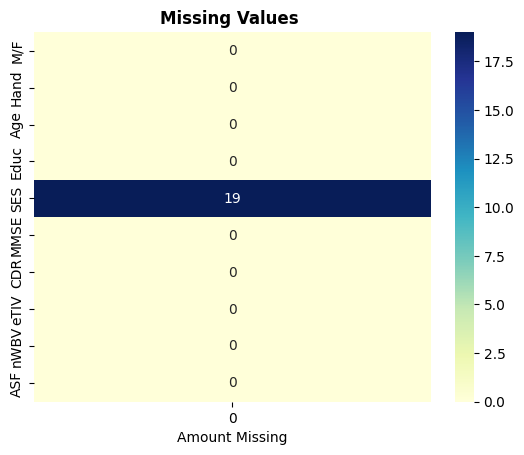

In [11]:
plt.title('Missing Values ',fontweight='bold')
ax=sns.heatmap(data_cross.isna().sum().to_frame(),annot=True,fmt='d',cmap='YlGnBu',cbar=True)
ax.set_xlabel('Amount Missing')
plt.show()

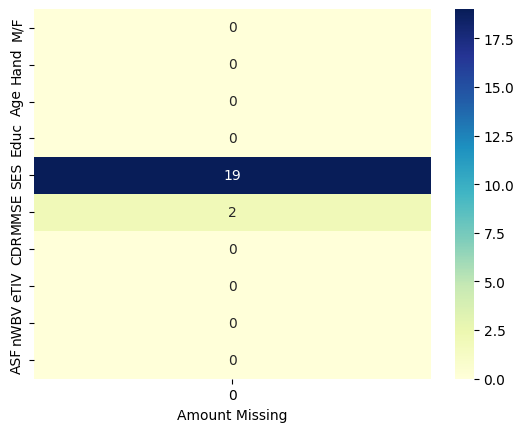

In [12]:
ax=sns.heatmap(data_long.isna().sum().to_frame(),annot=True,fmt='d',cmap='YlGnBu',cbar=True)
ax.set_xlabel('Amount Missing')
plt.show()

Imputing columns using SimpleImputer

In [13]:
from sklearn.impute  import SimpleImputer
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(data[['SES']])
data[['SES']] = imputer.fit_transform(data[['SES']])

# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(data[['MMSE']])
data[['MMSE']] = imputer.fit_transform(data[['MMSE']])


In [14]:
data.isna().sum()

,0
M/F,0
Hand,0
Age,0
Educ,0
SES,0
MMSE,0
CDR,0
eTIV,0
nWBV,0
ASF,0


In [15]:
data

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
368,M,R,82,16.0,1.0,28.0,0.5,1693,0.694,1.037
369,M,R,86,16.0,1.0,26.0,0.5,1688,0.675,1.040
370,F,R,61,13.0,2.0,30.0,0.0,1319,0.801,1.331
371,F,R,63,13.0,2.0,30.0,0.0,1327,0.796,1.323


Encoding the Target variable using LabelEncoder

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['CDR'] = le.fit_transform(data['CDR'].values)

In [17]:
data = pd.get_dummies(data)

Plotting the distribution of classes on a barplot

In [18]:
import plotly.express as px

In [19]:
fig=px.pie(data_cross,names='Age', color_discrete_sequence=['#46205c', '#b74068'])
fig.update_layout(title='<b>Proportion of Age<b> ')
fig.show(renderer="colab")

<BarContainer object of 4 artists>

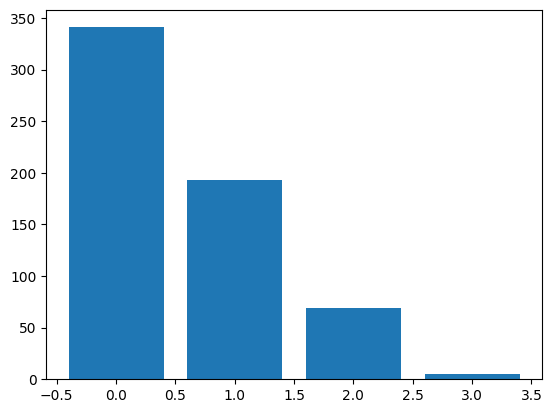

In [20]:
plt.bar(data['CDR'].unique(),data['CDR'].value_counts())

In [21]:
data = data.drop(data[data['CDR']==3].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 599 entries, 0 to 372
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     599 non-null    int64  
 1   Educ    599 non-null    float64
 2   SES     599 non-null    float64
 3   MMSE    599 non-null    float64
 4   CDR     599 non-null    int64  
 5   eTIV    599 non-null    int64  
 6   nWBV    599 non-null    float64
 7   ASF     599 non-null    float64
 8   M/F_F   599 non-null    bool   
 9   M/F_M   599 non-null    bool   
 10  Hand_R  599 non-null    bool   
dtypes: bool(3), float64(5), int64(3)
memory usage: 43.9 KB


In [22]:
y = data.pop('CDR')
x = data

Normalizing the data

In [23]:
x = StandardScaler().fit_transform(x)

Dividing dataset into train and test sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42,test_size=0.3)

In [25]:
!pip install --no-cache-dir scikit-learn==1.5.2

We will try hyperparameter tuning using cross-validation for XGBClassifier

In [40]:
from xgboost import XGBClassifier
FOLDS = 5

parametros_xgb = {
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "n_estimators":range(1,1000)
    }
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model_xgb = XGBClassifier(eval_metric='mlogloss')
X_train = X_train.astype(np.float32)
y_train = y_train.astype(int)
xgb_random = RandomizedSearchCV(estimator = model_xgb, param_distributions = parametros_xgb, n_iter = 100, cv = FOLDS,
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
xgb_random.fit(X_train, y_train)

xgb_random.best_params_

{'n_estimators': 583, 'max_depth': 5, 'learning_rate': 0.5}

In [27]:
model_xgb = xgb_random.best_estimator_
model_xgb.fit(X_train,y_train)
model_xgb.score(X_test,y_test)

0.7722222222222223

Trying hyperparameter tuning of GradientBoostingClassifier

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

FOLDS = 10

parametros_gb = {
    "loss": ["log_loss"],  # 'log_loss' is the correct value for this parameter
    "learning_rate": [0.01, 0.025, 0.005, 0.5, 0.075, 0.1, 0.15, 0.2, 0.3, 0.8, 0.9],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Integer values for min_samples_split
    "min_samples_leaf": [1, 2, 3, 5, 8, 10, 15, 20, 40, 50, 55, 60, 65, 70, 80, 85, 90, 100],
    "max_depth": [3, 5, 8, 10, 15, 20, 25, 30, 40, 50],
    "max_features": ["log2", "sqrt"],
    "criterion": ["friedman_mse", "squared_error"],  # Corrected criterion
    "subsample": [0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators": range(1, 100)
}

model_gb = GradientBoostingClassifier()

gb_random = RandomizedSearchCV(estimator=model_gb,
                               param_distributions=parametros_gb,
                               n_iter=100,
                               cv=FOLDS,
                               verbose=0,
                               random_state=42,
                               n_jobs=-1,
                               scoring='accuracy')

gb_random.fit(X_train, y_train)

print(gb_random.best_params_)


{'subsample': 0.9, 'n_estimators': 77, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 25, 'loss': 'log_loss', 'learning_rate': 0.3, 'criterion': 'friedman_mse'}


In [29]:
model_gb = gb_random.best_estimator_
print(model_gb.score(X_test,y_test))

0.8333333333333334


In [30]:
cross_val_score(model_gb, x, y, cv=10, scoring='accuracy').mean()

0.8163559322033898

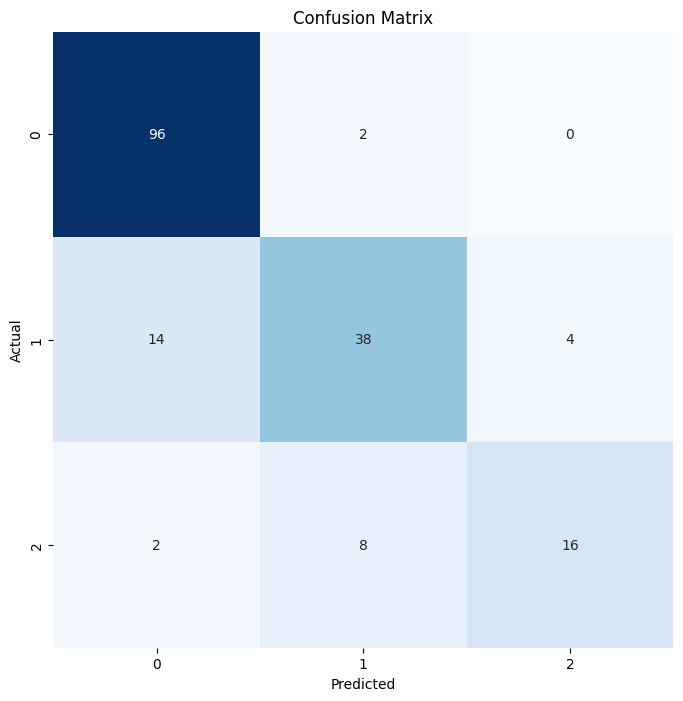

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.86      0.98      0.91        98
           1       0.79      0.68      0.73        56
           2       0.80      0.62      0.70        26

    accuracy                           0.83       180
   macro avg       0.82      0.76      0.78       180
weighted avg       0.83      0.83      0.83       180



In [31]:
y_pred = model_gb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

Trying hyperparamete tuning of DecisionTreeClassifier

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search over
parametros_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Create the Decision Tree classifier
model_dt = DecisionTreeClassifier()

# Create a GridSearchCV object to perform hyperparameter tuning
dt_grid = GridSearchCV(estimator=model_dt, param_grid=parametros_dt, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)

# Get the best hyperparameters
best_params = dt_grid.best_params_

In [33]:
best_dt_model = dt_grid.best_estimator_  # Get the best Decision Tree model
accuracy = best_dt_model.score(X_test, y_test)  # Calculate accuracy on the test set
print("Accuracy:", accuracy)

Accuracy: 0.7277777777777777


Trying hyperparameter tuning of Logistic Regression

In [37]:
param_grid = [
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1'],
        'solver': ['liblinear'],
        'max_iter': [100, 500, 1000]
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [100, 500, 1000]
    }
]

# Initialize GridSearchCV
lr_grid = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit the model
lr_grid.fit(X_train, y_train)

# Evaluate the best model
best_lr_model = lr_grid.best_estimator_
accuracy = best_lr_model.score(X_test, y_test)

print("Best Parameters:", lr_grid.best_params_)
print("Accuracy:", accuracy)


Best Parameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.7111111111111111


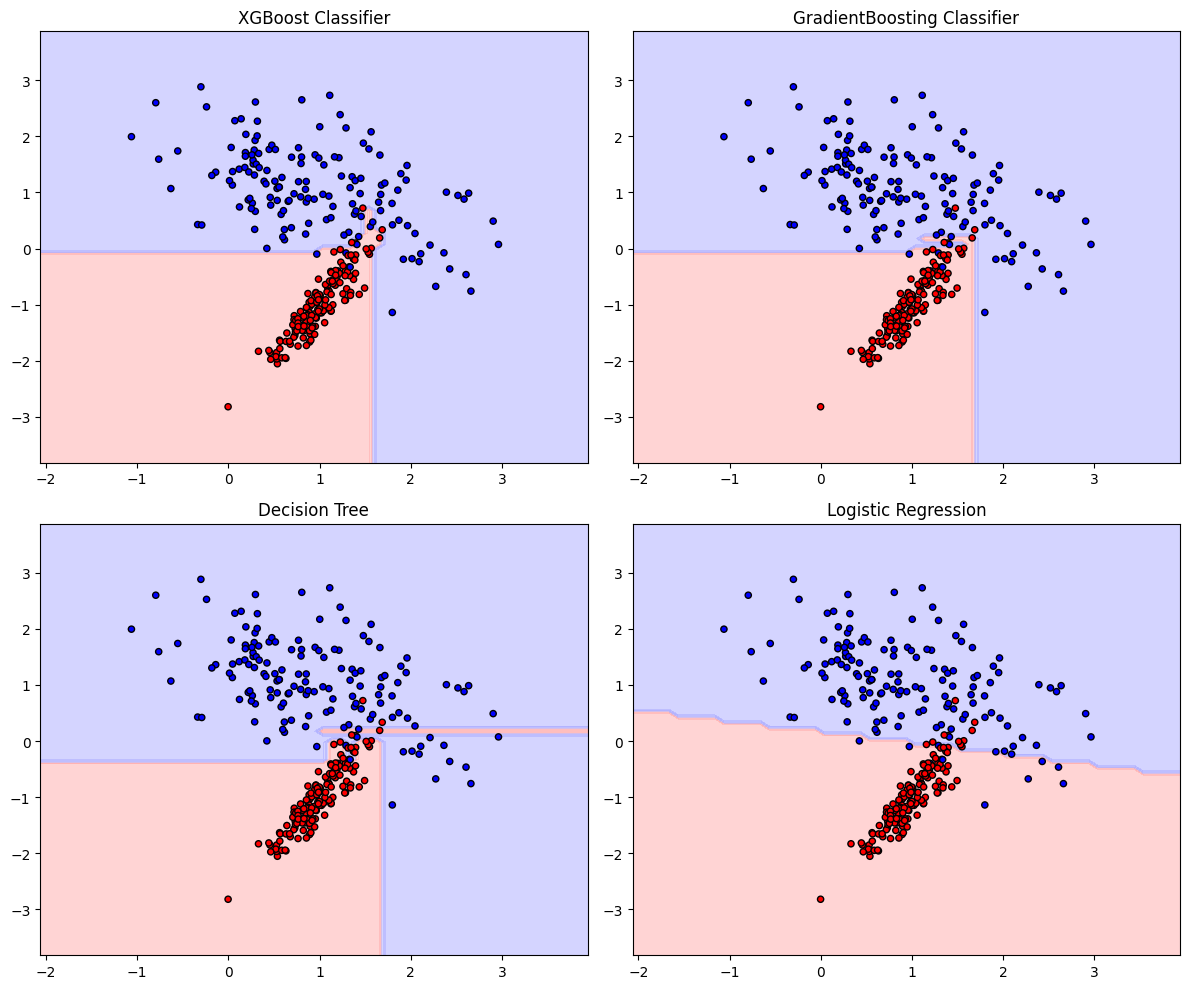

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from matplotlib.colors import ListedColormap

# Generate a synthetic dataset for classification
X, y = make_classification(n_samples=300, n_features=2, n_classes=2, n_clusters_per_class=1, n_redundant=0, random_state=42)

# Create mesh grid for decision boundary plotting
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Create the classifiers
classifiers = [
    XGBClassifier(),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    LogisticRegression()
]

classifier_names = [
    'XGBoost Classifier',
    'GradientBoosting Classifier',
    'Decision Tree',
    'Logistic Regression'
]

# Create subplots for decision boundary visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
models = zip(classifiers, classifier_names)

for (model, name), ax in zip(models, axes.ravel()):
    model.fit(X, y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Create a colormap for the plot
    cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_points = ListedColormap(['#FF0000', '#0000FF'])

    ax.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_points, edgecolor='k', s=20)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(name)

plt.tight_layout()
plt.show()